# CIFAR10 tutorial notebook
The goal of this notebook is for me to famirliarize myself with the basics of pytorch by fitting a CNN on CIFAR10.

## Setup

### Imports

In [1]:
%matplotlib inline

from timeit import timeit

import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from torch import optim
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas import DataFrame as DF
import torchvision.transforms as transforms

from trainer import Trainer

### Search for an accelerator

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Trained model pipeline

### Data extraction

In [3]:
# The output of torchvision datasets are PILImage images of range [0,1]. We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


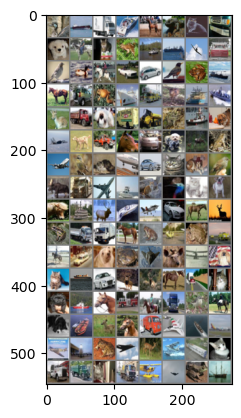

bird  ship  truck ship  horse frog  cat   truck dog   horse cat   frog  ship  ship  plane truck bird  bird  horse car   car   bird  frog  ship  horse car   frog  ship  truck deer  ship  ship  deer  truck dog   truck truck frog  ship  dog   plane dog   truck horse car   dog   deer  frog  plane bird  cat   plane car   cat   dog   bird  deer  truck plane ship  cat   bird  cat   dog   horse ship  deer  ship  plane car   horse deer  frog  truck truck horse frog  plane frog  truck horse car   dog   frog  plane deer  plane dog   cat   ship  car   deer  deer  horse truck cat   dog   ship  horse truck horse truck bird  horse dog   ship  deer  horse truck plane ship  plane plane plane frog  plane deer  plane truck cat   truck truck cat   truck plane plane frog  ship 


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Model, optimizer and trainer defenition

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        NB_CONV1_KERNLS = 16
        self.conv1 = nn.Conv2d(3, NB_CONV1_KERNLS, 7)
        self.batch_norm_1 = nn.BatchNorm2d(NB_CONV1_KERNLS)
        self.pool = nn.MaxPool2d(2, 2)
        NB_CONV2_KERNLS = 32
        self.conv2 = nn.Conv2d(16, NB_CONV2_KERNLS, 5)
        self.batch_norm_2 = nn.BatchNorm2d(NB_CONV2_KERNLS)
        self.fc1 = nn.Linear(NB_CONV2_KERNLS * (8 // 2) ** 2 , 300)
        self.fc2 = nn.Linear(300, 10)

    def forward(self, x:torch.Tensor):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch_norm_1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm_2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), 1)
        return x

model = Net().cuda()
trainer = Trainer(
    model,
    optimizer = optim.Adam(model.parameters())
)

### Train the network

In [6]:
training_metrics = trainer.optimize_nn(
    29,
    trainloader,
    testloader,
    plt_kwargs=dict(x="epoch", y=["train_loss", "train_accuracy", "test_loss", "test_accuracy"], height=600),
)

{'x': 'epoch', 'y': ['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'], 'height': 600}


Resource temporarily unavailable (src/thread.cpp:241)


RuntimeError: DataLoader worker (pid(s) 14733) exited unexpectedly

### Save model

In [ ]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


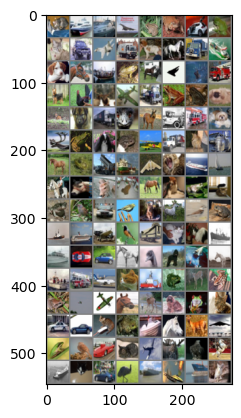

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [ ]:
model = Net(32)
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [ ]:
len(testloader.dataset)

10000

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [ ]:
x, y = next(iter(testloader))
y

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])

In [ ]:
y_pred = model(x)
(torch.max(y_pred, 1)[1] == y).sum()

tensor(92)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.7 %
Accuracy for class: car   is 81.8 %
Accuracy for class: bird  is 56.0 %
Accuracy for class: cat   is 48.0 %
Accuracy for class: deer  is 49.7 %
Accuracy for class: dog   is 42.5 %
Accuracy for class: frog  is 74.0 %
Accuracy for class: horse is 67.0 %
Accuracy for class: ship  is 82.5 %
Accuracy for class: truck is 65.6 %


Where do I go next?
===================

-   `Train neural nets to play video games </intermediate/reinforcement_q_learning>`{.interpreted-text
    role="doc"}
-   [Train a state-of-the-art ResNet network on
    imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
-   [Train a face generator using Generative Adversarial
    Networks](https://github.com/pytorch/examples/tree/master/dcgan)
-   [Train a word-level language model using Recurrent LSTM
    networks](https://github.com/pytorch/examples/tree/master/word_language_model)
-   [More examples](https://github.com/pytorch/examples)
-   [More tutorials](https://github.com/pytorch/tutorials)


In [ ]:
del dataiter